In [21]:
using Dates, JuMP, Gurobi, Plots, Logging

push!(LOAD_PATH, dirname(@__DIR__))
using ShelfSpaceAllocation

In [2]:
"""Relax-and-fix heuristic."""
function relax_and_fix(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
        P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, block_partitions, optimizer, w_1, w_2, w_3)
    # Remember fixed blocks and values
    relaxed_blocks = block_partitions[2:end]
    # TODO: test fixing related n_ps variables too for faster runtime
    fixed_blocks = []
    z_bs = []
    x_bs = []
    b_bs = []
    model = nothing
    for block in block_partitions
        # Solve the shelf space allocation model with a subset of blocks
        model = shelf_space_allocation_model(
            products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
            D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
            H_p, SL, w_1, w_2, w_3)

        # Relaxed values
        for relaxed_block in relaxed_blocks
            for b in relaxed_block
                for s in shelves
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    unset_binary(model.obj_dict[:z_bs_f][b, s])
                    unset_binary(model.obj_dict[:z_bs_l][b, s])
                end
            end
        end

        # Fixed values
        for (i, fixed_block) in enumerate(fixed_blocks)
            for b in fixed_block
                for s in shelves
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    fix(model.obj_dict[:x_bs][b, s], x_bs[i][b, s], force=true)
                    fix(model.obj_dict[:b_bs][b, s], b_bs[i][b, s], force=true)
                    fix(model.obj_dict[:z_bs][b, s], z_bs[i][b, s], force=true)
                end
            end
        end

        optimize!(model, optimizer)

        if termination_status(model) == MOI.INFEASIBLE
            exit()
        end

        # Decrease relaxed blocks
        relaxed_blocks = relaxed_blocks[2:end]

        # TODO: move x_bs as far left as possible without overlapping
        push!(fixed_blocks, block)
        push!(x_bs, value.(model.obj_dict[:x_bs]))
        push!(b_bs, value.(model.obj_dict[:b_bs]))
        push!(z_bs, value.(model.obj_dict[:z_bs]))
    end

    return model
end

relax_and_fix

In [3]:
"""Fix-and-optimize heuristic."""
function fix_and_optimize(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
        P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, z_bs, w_1, w_2, w_3)

    model = shelf_space_allocation_model(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
        D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, w_1, w_2, w_3)

    for b in blocks
        # Pad with zeros and find 0-1 boundaries using diff
        difference = diff(vcat([0], z_bs[b, :], [0]))
        # Fix a subset of z_bs variables
        i = 1
        while i <= length(difference)
            if abs(difference[i]) == 1
                i += 2
            else
                s = i - 1
                if s > 0
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    fix(model.obj_dict[:z_bs][b, s], z_bs[b, s])
                end
                i += 1
            end
        end
    end

    return model
end

fix_and_optimize

In [4]:
# --- Arguments ---
time_limit = 5*60 # Seconds
case = "medium"
block_partitions = [[7, 1], [6, 8], [2, 4], [9, 3, 5]]
product_path = joinpath(@__DIR__, "instances", case, "products.csv")
shelf_path = joinpath(@__DIR__, "instances", case, "shelves.csv")
output_dir = joinpath(@__DIR__, "output", case, string(Dates.now()));
# ---

In [5]:
parameters = load_parameters(product_path, shelf_path)
(products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps, D_p,
    N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p, SK_p, SL, 
    empty_space_penalty, shortage_penalty, shelf_up_down_penalty) = parameters;

In [6]:
optimizer = with_optimizer(
    Gurobi.Optimizer,
    TimeLimit=time_limit,
    MIPFocus=3,
    MIPGap=0.01,
    # Presolve=2,
)
model1 = relax_and_fix(
    products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
    P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
    H_p, SL, block_partitions, optimizer, empty_space_penalty,
    shortage_penalty, shelf_up_down_penalty);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 6108 rows, 2640 columns and 25100 nonzeros
Variable types: 740 continuous, 1900 integer (353 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+04]
  Objective range  [7e-03, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 96983.047000
Presolve removed 2759 rows and 779 columns
Presolve time: 0.03s
Presolved: 3349 rows, 1861 columns, 15965 nonzeros
Variable types: 246 continuous, 1615 integer (484 binary)
Presolve removed 208 rows and 208 columns
Presolved: 3141 rows, 1653 columns, 14482 nonzeros


Root relaxation: objective 3.680131e+03, 1971 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3680.13131    0  201 96983.0470 3680.13131  96.2%     -    0s
H    0  

In [7]:
model = fix_and_optimize(
    products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
    P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
    H_p, SL, value.(model1.obj_dict[:z_bs]), empty_space_penalty,
    shortage_penalty, shelf_up_down_penalty);

In [8]:
optimize!(model, optimizer)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 6108 rows, 2640 columns and 25100 nonzeros
Variable types: 641 continuous, 1999 integer (452 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+04]
  Objective range  [7e-03, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 4940 rows and 1495 columns
Presolve time: 0.01s
Presolved: 1168 rows, 1145 columns, 5862 nonzeros
Variable types: 81 continuous, 1064 integer (368 binary)
Found heuristic solution: objective 85281.467000
Presolve removed 240 rows and 201 columns
Presolved: 928 rows, 944 columns, 4779 nonzeros


Root relaxation: objective 6.114157e+03, 555 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6114.15699    0  148 85281.4670 6114.15699  92.8%     -    0s
H    0     0 

In [9]:
variables = Dict(k => value.(v) for (k, v) in model.obj_dict)
n_ps = variables[:n_ps]
s_p = variables[:s_p]
o_s = variables[:o_s]
b_bs = variables[:b_bs]
x_bs = variables[:x_bs]
z_bs = variables[:z_bs];

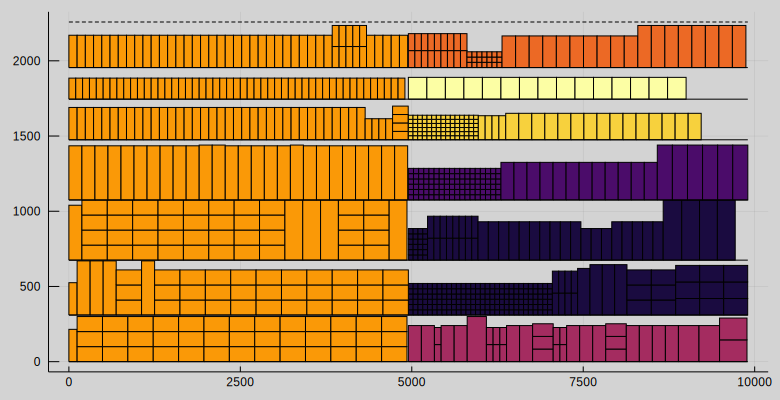

In [10]:
p1 = planogram(products, shelves, blocks, P_b, H_s, H_p, W_p, W_s, SK_p, n_ps, o_s, x_bs)

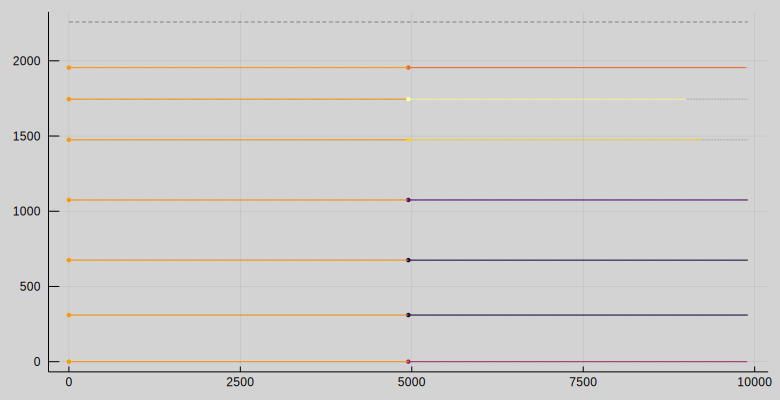

In [16]:
p2 = block_allocation(shelves, blocks, H_s, W_s, b_bs, x_bs, z_bs)

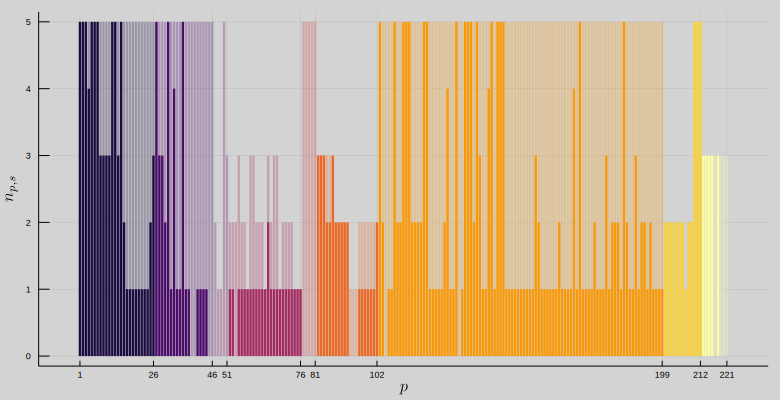

In [12]:
p3 = product_facings(products, shelves, blocks, P_b, N_p_max, n_ps)

In [ ]:
# FIXME
# p4 = demand_and_sales(blocks, P_b, D_p, s_p)

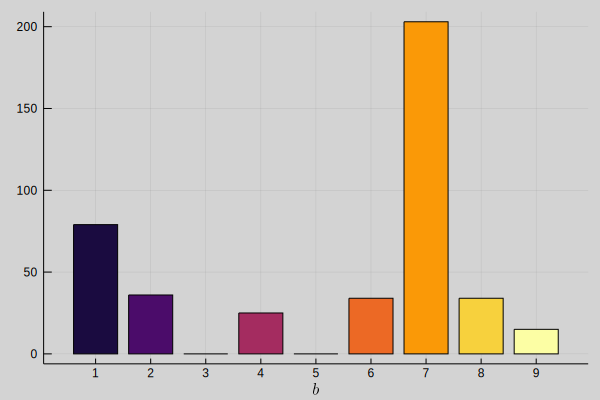

In [13]:
p5 = fill_amount(shelves, blocks, P_b, n_ps)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


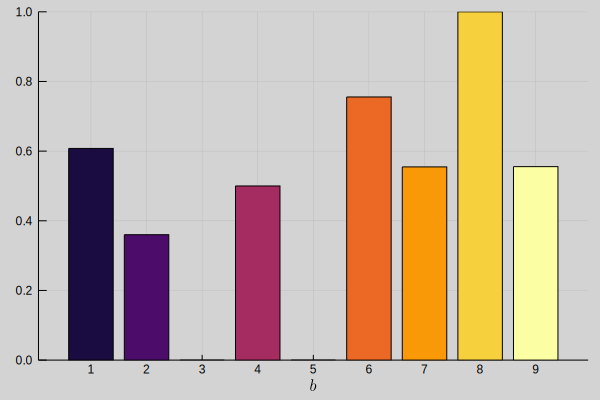

In [20]:
p6 = fill_percentage(
    n_ps, products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
    D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p,
    with_optimizer(Gurobi.Optimizer, TimeLimit=60, LogToConsole=false))